In [147]:
from pyscf import gto, scf, cc
import numpy as np
from jax import numpy as jnp
from jax import vmap, jvp, jit
import jax
from functools import partial

a = 2 # 2aB
nH = 2
atoms = ""
for i in range(nH):
    atoms += f"N {i*a:.5f} 0.00000 0.00000 \n"

mol = gto.M(atom=atoms, basis="sto6g", unit='B', spin=0, verbose=4)
mol.build()

mf = scf.UHF(mol)
mf.kernel()

mo = mf.stability()[0]
dm = mf.make_rdm1(mo,mf.mo_occ)
mf.kernel(dm0=dm)
mo = mf.stability()[0]
dm = mf.make_rdm1(mo,mf.mo_occ)
mf.kernel(dm0=dm)


nfrozen = 0
mycc = cc.CCSD(mf,frozen=nfrozen)
mycc.kernel()[0]

System: uname_result(system='Linux', node='sharmagroup-rn', release='6.14.0-37-generic', version='#37~24.04.1-Ubuntu SMP PREEMPT_DYNAMIC Thu Nov 20 10:25:38 UTC 2', machine='x86_64')  Threads 16
Python 3.11.14 (main, Oct 21 2025, 18:31:21) [GCC 11.2.0]
numpy 2.3.1  scipy 1.16.2  h5py 3.14.0
Date: Thu Jan 29 22:28:57 2026
PySCF version 2.11.0
PySCF path  /home/sharmagroup/sharmagroup/pyscf
GIT HEAD (branch master) 3d1768f5e33b144b606c3d2c81c12ee54d794501

[ENV] PYSCF_EXT_PATH /home/sharmagroup/sharmagroup/pyscf-forge
[CONFIG] conf_file None
[INPUT] verbose = 4
[INPUT] num. atoms = 2
[INPUT] num. electrons = 14
[INPUT] charge = 0
[INPUT] spin (= nelec alpha-beta = 2S) = 0
[INPUT] symmetry False subgroup None
[INPUT] Mole.unit = B
[INPUT] Symbol           X                Y                Z      unit          X                Y                Z       unit  Magmom
[INPUT]  1 N      0.000000000000   0.000000000000   0.000000000000 AA    0.000000000000   0.000000000000   0.000000000000 Bohr 

np.float64(-0.14383543953658998)

In [158]:
options = {'n_eql': 3,
           'n_prop_steps': 50,
            'n_ene_blocks': 1,
            'n_sr_blocks': 5,
            'n_blocks': 10,
            'n_walkers': 200,
            'seed': 2,
            'walker_type': 'uhf',
            'trial': 'uhf',
            'free_projection': True,
            'dt':0.005,
            'use_gpu': False
            }

from ad_afqmc import pyscf_interface
pyscf_interface.prep_afqmc(mycc,options,chol_cut=1e-5)

option_file='options.bin'
import pickle
with open(option_file, 'wb') as f:
    pickle.dump(options, f)

#
# Preparing AFQMC calculation
# If you import pyscf cc modules and use MPI for AFQMC in the same script, finalize MPI before calling the AFQMC driver.
# Calculating Cholesky integrals
# Finished calculating Cholesky integrals
#
# Size of the correlation space:
# Number of electrons: (7, 7)
# Number of basis functions: 10
# Number of Cholesky vectors: 42
#


In [149]:
import numpy as np
from jax import random
from jax import numpy as jnp
from functools import partial
from ad_afqmc import config
from ad_afqmc import mpi_jax

In [159]:
config.setup_jax()
MPI = config.setup_comm()
comm = MPI.COMM_WORLD
size = comm.Get_size()
rank = comm.Get_rank()

print = partial(print, flush=True)

ham_data, ham, prop, trial, wave_data, sampler, observable, options, _ = (mpi_jax._prep_afqmc())

# Hostname: sharmagroup-rn
# System Type: Linux
# Machine Type: x86_64
# Processor: x86_64
# Number of MPI ranks: 1
#
# norb: 10
# nelec: (7, 7)
#
# n_eql: 3
# n_prop_steps: 50
# n_ene_blocks: 1
# n_sr_blocks: 5
# n_blocks: 10
# n_walkers: 200
# seed: 2
# walker_type: uhf
# trial: uhf
# free_projection: True
# dt: 0.005
# use_gpu: False
# n_exp_terms: 6
# orbital_rotation: True
# do_sr: True
# symmetry: False
# save_walkers: False
# ene0: 0.0
# n_batch: 1
# LNO: False
# orbE: 0
# maxError: 0.001
#


In [151]:
from ad_afqmc import linalg_utils
from jax import lax

@partial(jit, static_argnums=(0))
def propagate_free(prop, ham_data, prop_data, fields):
    shift_term = jnp.einsum("wg,sg->sw", fields, ham_data["mf_shifts_fp"])
    constants = jnp.einsum(
        "sw,s->sw",
        jnp.exp(-jnp.sqrt(prop.dt) * shift_term),
        jnp.exp(prop.dt * ham_data["h0_prop_fp"]),
    )
    prop_data["walkers"] = prop._apply_trotprop(
        ham_data, prop_data["walkers"], fields
    )
    prop_data["walkers"] = prop._multiply_constant(prop_data["walkers"], constants)
    prop_data["walkers"], norms = linalg_utils.qr_vmap_uhf(prop_data["walkers"])
    prop_data["weights"] *= jnp.real(norms[0] * norms[1])
    # prop_data = prop.stochastic_reconfiguration_local(prop_data)
    return prop_data

@partial(jit, static_argnums=(3))
def fp_step(prop_data, fields, ham_data, prop):
    """A Free propagation step of nwalkers"""
    prop_data = propagate_free(prop, ham_data, prop_data, fields)
    # prop_data = prop.stochastic_reconfiguration_local(prop_data)
    return prop_data, fields

@partial(jit, static_argnums=(2, 3, 5))
def fp_block(prop_data, ham_data, prop, trial, wave_data, sampler):
    """free propagation for a block of (n_prop_steps, n_walkers)."""
    prop_data["key"], subkey = random.split(prop_data["key"])
    fields = random.normal(
        subkey,
        shape=(
            sampler.n_prop_steps,
            prop.n_walkers,
            ham_data["chol"].shape[0],
        ),
    )
    _step_scan_wrapper = lambda x, y: fp_step(x, y, ham_data, prop)
    prop_data, _ = lax.scan(_step_scan_wrapper, prop_data, fields)

    prop_data["overlaps"] = (trial.calc_overlap(prop_data["walkers"], wave_data))
    prop_data["weights"] = prop_data["weights"] / jnp.sum(prop_data["weights"])
    block_weight = jnp.sum(prop_data["overlaps"] * prop_data["weights"])
    energy_samples = trial.calc_energy(prop_data["walkers"], ham_data, wave_data)
    energy_samples = jnp.where(
        jnp.abs(energy_samples - prop_data["e_estimate"]
                ) > jnp.sqrt(2./prop.dt), prop_data["e_estimate"],
                energy_samples)
    block_energy = jnp.sum(
        energy_samples * prop_data["overlaps"] * prop_data["weights"]
        ) / jnp.sum(prop_data["overlaps"] * prop_data["weights"])
    block_weight = jnp.sum(prop_data["overlaps"])
    return prop_data, (block_energy, block_weight)


@jit
def c_stochastic_reconfiguration_uhf(walkers, weights, zeta):
    nwalkers = walkers[0].shape[0]
    cumulative_weights = jnp.cumsum(jnp.abs(weights))
    total_weight = cumulative_weights[-1]
    average_weight = total_weight / nwalkers
    weights = jnp.ones(nwalkers,dtype=jnp.complex128) * average_weight
    z = total_weight * (jnp.arange(nwalkers) + zeta) / nwalkers
    indices = vmap(jnp.searchsorted, in_axes=(None, 0))(cumulative_weights, z)
    walkers[0] = walkers[0][indices]
    walkers[1] = walkers[1][indices]
    return walkers, weights

@partial(jit, static_argnums=(2, 3, 5))
def fp_block_sr(prop_data, ham_data, prop, trial, wave_data, sampler):
    """free propagation for a block of (n_prop_steps, n_walkers)."""
    prop_data["key"], subkey = random.split(prop_data["key"])
    fields = random.normal(
        subkey,
        shape=(
            sampler.n_prop_steps,
            prop.n_walkers,
            ham_data["chol"].shape[0],
        ),
    )
    _step_scan_wrapper = lambda x, y: fp_step(x, y, ham_data, prop)
    prop_data, _ = lax.scan(_step_scan_wrapper, prop_data, fields)

    prop_data["overlaps"] = (trial.calc_overlap(prop_data["walkers"], wave_data))
    prop_data["weights"] = prop_data["weights"] / jnp.sum(prop_data["weights"])

    energy_samples = trial.calc_energy(prop_data["walkers"], ham_data, wave_data)
    energy_samples = jnp.where(
        jnp.abs(energy_samples - prop_data["e_estimate"]
                ) > jnp.sqrt(2./prop.dt), prop_data["e_estimate"],
                energy_samples)
    
    block_weight = jnp.sum(prop_data["overlaps"] * prop_data["weights"])
    
    block_energy = jnp.sum(
        energy_samples * prop_data["overlaps"] * prop_data["weights"]
        ) / jnp.sum(prop_data["overlaps"] * prop_data["weights"])

    prop_data = prop.stochastic_reconfiguration_local(prop_data)
    # prop_data["key"], subkey = random.split(prop_data["key"])
    # zeta = random.uniform(subkey)
    # prop_data["walkers"], prop_data["weights"] \
    #     = c_stochastic_reconfiguration_uhf(prop_data["walkers"], prop_data["weights"], zeta)

    return prop_data, (block_energy, block_weight)


@partial(jit, static_argnums=(2, 3, 5))
def fp_block_abs(prop_data, ham_data, prop, trial, wave_data, sampler):
    """free propagation for a block of (n_prop_steps, n_walkers)."""
    prop_data["key"], subkey = random.split(prop_data["key"])
    fields = random.normal(
        subkey,
        shape=(
            sampler.n_prop_steps,
            prop.n_walkers,
            ham_data["chol"].shape[0],
        ),
    )
    _step_scan_wrapper = lambda x, y: fp_step(x, y, ham_data, prop)
    prop_data, _ = lax.scan(_step_scan_wrapper, prop_data, fields)

    prop_data["overlaps"] = (trial.calc_overlap(prop_data["walkers"], wave_data))
    prop_data["weights"] = prop_data["weights"] / jnp.sum(prop_data["weights"])

    energy_samples = trial.calc_energy(prop_data["walkers"], ham_data, wave_data)

    block_energy = jnp.sum(
        energy_samples * jnp.abs(prop_data["overlaps"]) * prop_data["weights"]
        ) / jnp.sum(jnp.abs(prop_data["overlaps"]) * prop_data["weights"])
    
    block_weight = jnp.sum(jnp.abs(prop_data["overlaps"]) * prop_data["weights"])

    prop_data["key"], subkey = random.split(prop_data["key"])
    zeta = random.uniform(subkey)
    prop_data["walkers"], prop_data["weights"] \
        = c_stochastic_reconfiguration_uhf(prop_data["walkers"], prop_data["weights"], zeta)
    # prop_data = prop.stochastic_reconfiguration_local(prop_data)
    return prop_data, (block_energy, block_weight)

In [161]:
seed = options["seed"]
init_walkers = None
trial_rdm1 = trial.get_rdm1(wave_data)
if "rdm1" not in wave_data:
    wave_data["rdm1"] = trial_rdm1
ham_data = ham.build_measurement_intermediates(ham_data, trial, wave_data)
ham_data = ham.build_propagation_intermediates(ham_data, prop, trial, wave_data)

def init_prop(prop, trial, wave_data, ham_data, seed, init_walkers=None):
    prop_data = prop.init_prop_data(trial, wave_data, ham_data, init_walkers)
    # if jnp.abs(jnp.sum(prop_data["overlaps"])) < 1.0e-6:
    #     raise ValueError(
    #         "Initial overlaps are zero. Pass walkers with non-zero overlap."
    #     )
    # prop_data["weights"] = jnp.ones(prop.n_walkers,dtype=jnp.complex128)
    prop_data["weights"] = jnp.ones(prop.n_walkers)
    prop_data["key"] = random.PRNGKey(seed)

    prop_data["overlaps"] = trial.calc_overlap(prop_data["walkers"], wave_data)
    prop_data["n_killed_walkers"] = 0
    return prop_data

prop_data = init_prop(prop, trial, wave_data, ham_data, seed)
print(prop_data["e_estimate"])

-108.52346313844826


In [153]:
nstep = 100
fp_e = np.zeros(nstep+1,dtype=np.complex128)
fp_w = np.zeros(nstep+1,dtype=np.complex128)
fp_e[0] = prop_data["e_estimate"]
fp_w[0] = sum(prop_data["weights"])
for n in range(nstep):
    prop_data, (blk_e, blk_w) = \
        fp_block(prop_data, ham_data, prop, trial, wave_data, sampler)
    fp_e[n+1] = blk_e
    fp_w[n+1] = blk_w
    print(n+1, blk_e, blk_w)

1 (-108.57900733951958-0.0014745237999887794j) (-52.076892740670516+0.10022189635942891j)
2 (-108.6185122946154-0.002064702799546475j) (-22.762931586057313-0.493846913097726j)
3 (-108.63833573613579-0.0033623442964947777j) (-14.279593926717098-0.11834206466988081j)
4 (-108.64625226280003-0.005225537961682142j) (-12.682752822445023-0.5689991324759556j)
5 (-108.6655975321836-0.006104909907981379j) (-15.947658373147846-1.2743432617396715j)
6 (-108.63542351750326-0.003973649938371013j) (-11.942968429693087-0.5923712753622601j)
7 (-108.64964515761766+0.002853996255687802j) (-10.792466685884257+0.20265914771605456j)
8 (-108.65786049968773-0.0020827776259459314j) (-17.548973572649377+0.3034699143402964j)
9 (-108.68173496022287+0.008872181928898614j) (-8.435795974261502-0.16548170808643603j)
10 (-108.68305408712361+0.0035271162202161577j) (-13.473668565204093-1.1487456496165351j)
11 (-108.6839708368678+0.009634086203169759j) (-16.200048583508877+0.01629962436366439j)
12 (-108.71101975608721+0.

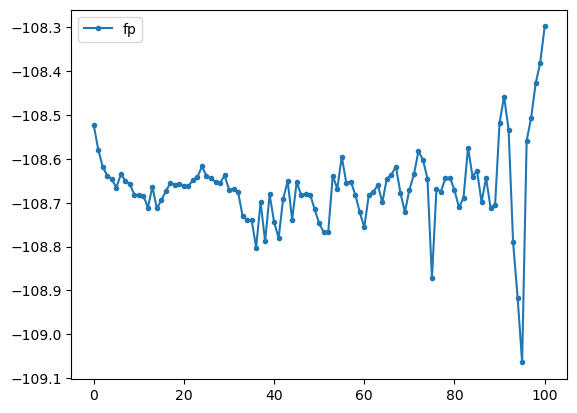

In [154]:
from matplotlib import pyplot as plt
# eg_avg = eg_sp.mean()
# eg_avg_std = np.std(eg_sp, ddof=1) / np.sqrt(len(eg_sp))
# et_avg = np.sum(wp_sp * et_sp) / np.sum(wp_sp)
# et_avg_std = np.std(et_sp, ddof=1) / np.sqrt(len(et_sp))

# print(f'AFQMC/Guide=CISD average = {eg_avg}, std = {eg_avg_std}')
# print(f'AFQMC/Trial=RHF  average = {et_avg}, std = {et_avg_std}')

plt.plot(fp_e.real,'.-',label='fp',color='C0')
# plt.plot([eg_avg]*len(eg_sp),'--',color='C0')
# plt.plot(et_sp,'.-',label='Trial(RHF)',color='C1')
# plt.plot([et_avg]*len(et_sp),'--',color='C1')

plt.legend()
plt.show()

In [162]:
prop_data = init_prop(prop, trial, wave_data, ham_data, seed)
print(prop_data["weights"])
print(prop_data["e_estimate"])

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1.]
-108.52346313844826


In [163]:
nstep = 100
fp_sr_e = np.zeros(nstep+1,dtype=np.complex128)
fp_sr_w = np.zeros(nstep+1,dtype=np.complex128)
fp_sr_e[0] = prop_data["e_estimate"]
fp_sr_w[0] = sum(prop_data["weights"])
for n in range(nstep):
    prop_data, (blk_e, blk_w) = \
        fp_block_sr(prop_data, ham_data, prop, trial, wave_data, sampler)
    fp_sr_e[n+1] = blk_e
    fp_sr_w[n+1] = blk_w
    print(n+1, blk_e, blk_w)

1 (-108.57858965671419+0.00025738606121497793j) (-1.3123291671089585-0.0003139017694445376j)
2 (-108.61420081241991+0.0013822261015294884j) (-3.2851940567058335+0.0040120431590959325j)
3 (-108.66835109929994+0.011173833410518152j) (-0.7441426187869441-0.0012645165408259398j)
4 (-108.67211394134922+0.007202909086634737j) (-0.5512920091004766-0.005785117746883506j)
5 (-108.75465625876159+0.00815693107171259j) (-0.56937923921118-0.000516817927588429j)
6 (-108.68036586929937+0.015534649266630597j) (-0.22663346594335787-0.004742510714131526j)
7 (-108.65852674294835-0.017657038325089854j) (-0.5119178220933875-0.01753530693687395j)
8 (-108.65423667578523+0.05172705806184005j) (-0.27885065104015794-0.04122992095013793j)
9 (-108.89498447138091+0.028902489101907083j) (-0.2791904451882685+0.028737482802884934j)
10 (-108.63930345013814-0.02808217612875137j) (-0.5497778347763743+0.016932057773300778j)
11 (-108.66467143838867-0.023490543797312576j) (-0.523692447696506+0.03690134763251935j)
12 (-108.

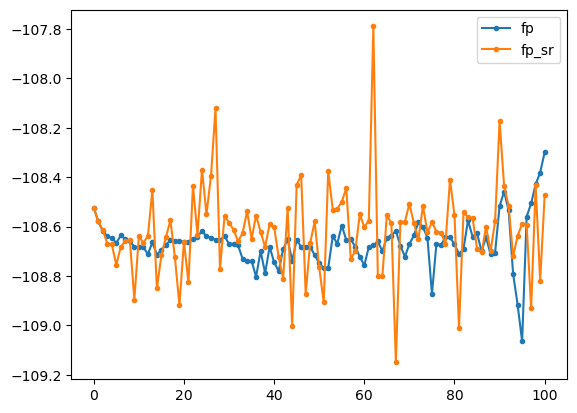

In [164]:
plt.plot(fp_e.real,'.-',label='fp',color='C0')
plt.plot(fp_sr_e.real,'.-',label='fp_sr',color='C1')
plt.legend()
plt.show()

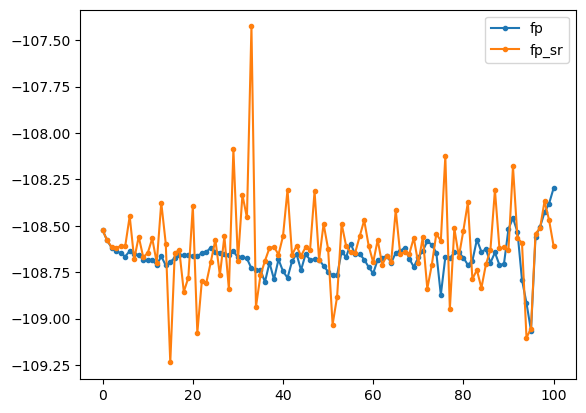

In [157]:
plt.plot(fp_e.real,'.-',label='fp',color='C0')
plt.plot(fp_sr_e.real,'.-',label='fp_sr',color='C1')
plt.legend()
plt.show()

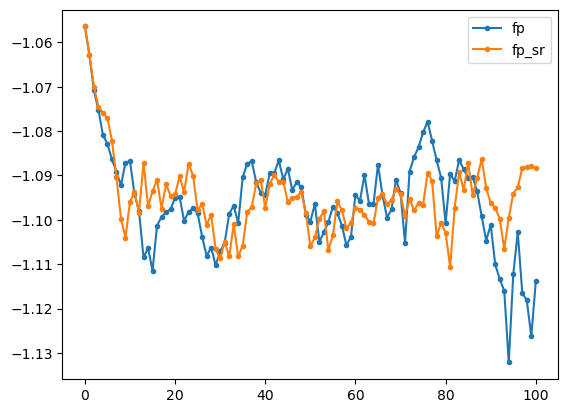

In [146]:
plt.plot(fp_e.real,'.-',label='fp',color='C0')
plt.plot(fp_sr_e.real,'.-',label='fp_sr',color='C1')
plt.legend()
plt.show()

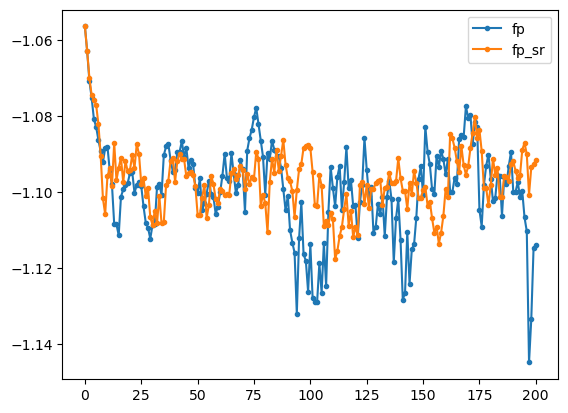

In [46]:
plt.plot(fp_e.real,'.-',label='fp',color='C0')
plt.plot(fp_sr_e.real,'.-',label='fp_sr',color='C1')
plt.legend()
plt.show()

In [115]:
prop_data = init_prop(prop, trial, wave_data, ham_data, seed)
print(prop_data["weights"])
print(prop_data["e_estimate"])

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]
-108.52346313844822


In [116]:
nstep = 100
fp_abs_e = np.zeros(nstep+1,dtype=np.complex128)
fp_abs_w = np.zeros(nstep+1,dtype=np.complex128)
fp_abs_e[0] = prop_data["e_estimate"]
fp_abs_w[0] = sum(prop_data["weights"])
for n in range(nstep):
    prop_data, (blk_e, blk_w) = \
        fp_block_abs(prop_data, ham_data, prop, trial, wave_data, sampler)
    fp_abs_e[n+1] = blk_e
    fp_abs_w[n+1] = blk_w
    print(n+1, blk_e, blk_w)

1 (-108.55612139611625+0.004015828477594734j) 0.8673800360293547
2 (-108.50832122157824+0.03940563174983206j) 0.9355515192047226
3 (-108.6322148184593-0.0029555317663996243j) 0.6078581964617031
4 (-108.5821274786314-0.03043555182860763j) 0.6699121409536732
5 (-108.346188620654+0.006972540518597901j) 5.06974547685107
6 (-108.79083817610834+0.04612905795295351j) 0.3949140074094235
7 (-108.63463985849117+0.038065693939267835j) 0.6132740168986578
8 (-108.74269069472606+0.0039969390379315j) 0.2969995608291219
9 (-108.64997483913555+0.0069392788691859325j) 0.5542595715218287
10 (-108.69801469573626+0.003623732618849086j) 0.44508936859177006
11 (-108.60941944503612-0.023917343909678913j) 0.58297909956796
12 (-108.57366841681268+0.036932509673389506j) 0.5128436890078778
13 (-108.44664256281452-0.0686019737935416j) 1.1593663652643373
14 (-108.58906459764232+0.08936131332361773j) 0.4486692456812014
15 (-108.65549533378245+0.006669348197795445j) 0.4913149886413442
16 (-108.84530902355733-0.001837

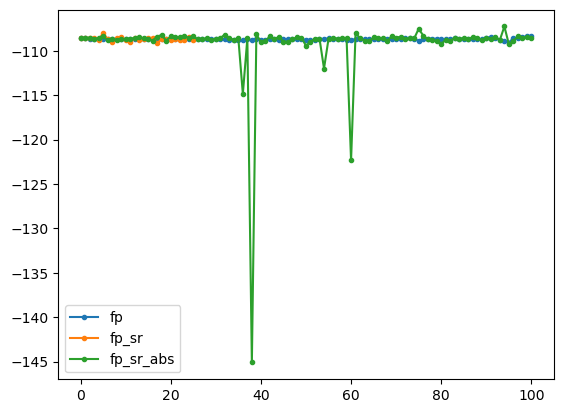

In [117]:
plt.plot(fp_e.real,'.-',label='fp',color='C0')
plt.plot(fp_sr_e.real,'.-',label='fp_sr',color='C1')
plt.plot(fp_abs_e.real,'.-',label='fp_sr_abs',color='C2')
plt.legend()
plt.show()

In [64]:
prop_data = init_prop(prop, trial, wave_data, ham_data, seed)
# print(prop_data["weights"])
# print(prop_data["e_estimate"])
nstep = 200
fp_abs2_e = np.zeros(nstep+1,dtype=np.complex128)
fp_abs2_w = np.zeros(nstep+1,dtype=np.complex128)
fp_abs2_e[0] = prop_data["e_estimate"]
fp_abs2_w[0] = sum(prop_data["weights"])
for n in range(nstep):
    prop_data, (blk_e, blk_w) = \
        fp_block_abs(prop_data, ham_data, prop, trial, wave_data, sampler)
    fp_abs2_e[n+1] = blk_e
    fp_abs2_w[n+1] = blk_w
    print(n+1, blk_e, blk_w)

1 (-1.0628548079724716+0.00022186128123466556j) 96.85316189998582
2 (-1.069942989607628+0.00036079249965208877j) 93.50845512479832
3 (-1.0744637131425452-0.0003360138431473421j) 91.45783654130103
4 (-1.0755908103827283-0.0007344084911181779j) 90.63575936081375
5 (-1.0769675383442803-0.00035562868703795445j) 89.93091574285907
6 (-1.0816797029302856-0.00264176588303383j) 87.70685392750835
7 (-1.0884218692893617-0.004209476356290903j) 84.21568054962061
8 (-1.0998205957418894-0.004877376706393424j) 80.18301357457565
9 (-1.102864646186332-0.0030240325889314603j) 78.48817908393082
10 (-1.093838875404351-0.0026650421165122966j) 82.01753784781623
11 (-1.0929904860902935-0.0021287709965954246j) 82.76807240149783
12 (-1.097188873098694-0.0033103513253432263j) 81.19407382276003
13 (-1.086634469658671-0.002451311239843642j) 85.49548506129342
14 (-1.0960253392355193-0.0005528367473872384j) 81.8645939742683
15 (-1.09246087633156+0.000732083419054176j) 82.79104069962608
16 (-1.0895453404027993+0.0040

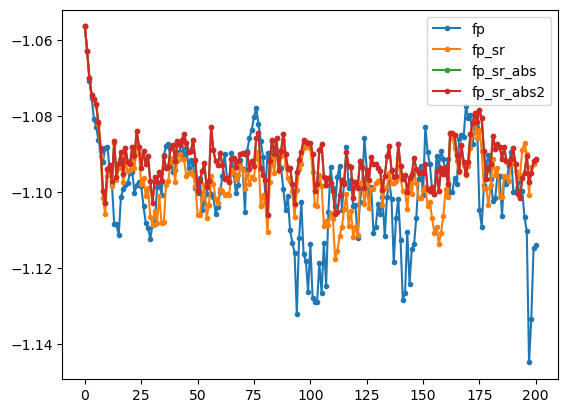

In [65]:
plt.plot(fp_e.real,'.-',label='fp',color='C0')
plt.plot(fp_sr_e.real,'.-',label='fp_sr',color='C1')
plt.plot(fp_abs_e.real,'.-',label='fp_sr_abs',color='C2')
plt.plot(fp_abs2_e.real,'.-',label='fp_sr_abs2',color='C3')
plt.legend()
plt.show()